In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
import time

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
BATCH_SIZE = 128

In [5]:
num_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(10),
    tv.transforms.ToTensor()
])

In [7]:
train_dataset = tv.datasets.FashionMNIST('.',
                                  train=True,
                                  transform=transforms,
                                  download=True)

test_dataset = tv.datasets.FashionMNIST('.',
                                 train=False,
                                 transform=transforms,
                                 download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

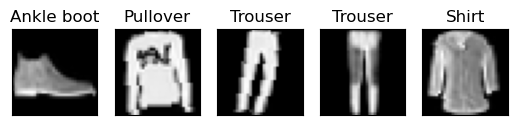

In [38]:
fig, axs = plt.subplots(1,5)
for i in range(5):
  axs[i].imshow(test_dataset[i][0].numpy().reshape(32,32), cmap='gray');
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(class_names[test_dataset[i][1]])

#CNN baseline

In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, num_classes)
)

In [11]:
model = model.to(device)

In [12]:
def evaluate_accuracy(data_iter, net, device):
  net.eval()
  acc_sum, n = torch.Tensor([0]).to(device), 0
  for X, y in data_iter:
      X, y = X.to(device), y.to(device)
      acc_sum += (net(X).argmax(axis=1) == y).sum()
      n += y.shape[0]
  return acc_sum.item() / n

In [13]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()
    log_loss = []
    log_acc_train = []
    log_acc_test = []
    net.train()

    begin_time = time.time()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        log_loss.append(train_l_sum / n)
        log_acc_train.append(train_acc_sum / n)
        log_acc_test.append(test_acc)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        scheduler.step()
    finish_time = time.time()
    training_time = finish_time - begin_time
    print(f'Training time: {int(training_time) // 60} min {training_time % 60 :.1f} sec')
    return log_loss, log_acc_train, log_acc_test

In [14]:
%%time
lr, num_epochs = 0.005, 20
trainer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(trainer, step_size=5, gamma=0.1)
log_l, log_acc_tr, log_acc_ts = train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0178, train acc 0.119, test acc 0.241, time 38.1 sec
epoch 2, loss 0.0155, train acc 0.381, test acc 0.459, time 38.2 sec
epoch 3, loss 0.0111, train acc 0.511, test acc 0.575, time 38.9 sec
epoch 4, loss 0.0095, train acc 0.607, test acc 0.629, time 36.5 sec
epoch 5, loss 0.0084, train acc 0.643, test acc 0.656, time 35.8 sec
epoch 6, loss 0.0079, train acc 0.660, test acc 0.657, time 37.2 sec
epoch 7, loss 0.0078, train acc 0.663, test acc 0.659, time 36.0 sec
epoch 8, loss 0.0077, train acc 0.665, test acc 0.661, time 36.9 sec
epoch 9, loss 0.0076, train acc 0.668, test acc 0.662, time 37.7 sec
epoch 10, loss 0.0076, train acc 0.670, test acc 0.665, time 37.9 sec
epoch 11, loss 0.0075, train acc 0.671, test acc 0.665, time 37.1 sec
epoch 12, loss 0.0075, train acc 0.671, test acc 0.664, time 38.7 sec
epoch 13, loss 0.0075, train acc 0.671, test acc 0.665, time 33.9 sec
epoch 14, loss 0.0075, train acc 0.671, test acc 0.664, time 34.6 sec
epoch 15, loss 0.0075, train 

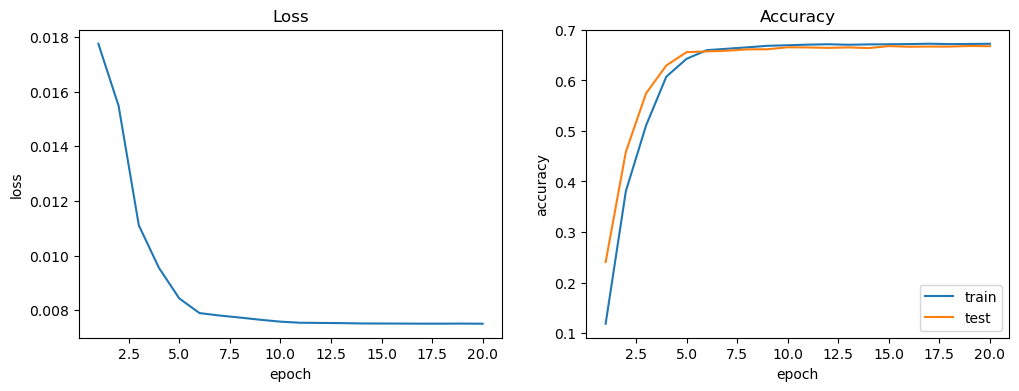

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(range(1, len(log_l) + 1), log_l)
axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(1, len(log_acc_tr) + 1), log_acc_tr, label='train')
axs[1].plot(range(1, len(log_acc_ts) + 1), log_acc_ts, label='test')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()

In [23]:
test_acc = evaluate_accuracy(test_iter, model, device)
print(f'accuracy: {test_acc*100:.1f}%')

accuracy: 66.8%


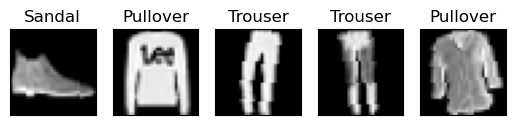

In [24]:
fig, axs = plt.subplots(1,5)
for i in range(5):
  axs[i].imshow(test_dataset[i][0].numpy().reshape(32,32), cmap='gray');
  axs[i].set_xticks([]), axs[i].set_yticks([])
  pred_label = model(test_dataset[i][0].unsqueeze(0).to(device)).argmax(axis=1)
  axs[i].set_title(class_names[pred_label])

#Resnet Finetuning

In [25]:
FINE_BATCH_SIZE = 64

fine_transforms = tv.transforms.Compose([
    tv.transforms.Resize(256),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(10),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda img: img.repeat(3, 1, 1)),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

fine_train_dataset = tv.datasets.FashionMNIST('.',
                                  train=True,
                                  transform=fine_transforms,
                                  download=True)

fine_test_dataset = tv.datasets.FashionMNIST('.',
                                 train=False,
                                 transform=fine_transforms,
                                 download=True)

fine_train_iter = torch.utils.data.DataLoader(fine_train_dataset, batch_size=FINE_BATCH_SIZE)
fine_test_iter = torch.utils.data.DataLoader(fine_test_dataset, batch_size=FINE_BATCH_SIZE)

In [26]:
fine_model = tv.models.resnet18(pretrained=True)
fine_model.fc = nn.Linear(fine_model.fc.in_features, num_classes)
fine_model = fine_model.to(device)

#freeze feature extractor
for name, param in fine_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

fine_model

C:\ProgramData\miniconda3\envs\ds_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\miniconda3\envs\ds_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Finetuned model download

fine_model = torch.load('fashion_model.pth', map_location=device)
fine_model.eval()

In [27]:
%%time
lr, num_epochs = 0.005, 10
fine_trainer = torch.optim.AdamW(fine_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(fine_trainer, step_size=5, gamma=0.1)
log_l, log_acc_tr, log_acc_ts = train(fine_model, fine_train_iter, fine_test_iter, fine_trainer, num_epochs, device)

epoch 1, loss 0.0061, train acc 0.863, test acc 0.883, time 184.7 sec
epoch 2, loss 0.0047, train acc 0.892, test acc 0.895, time 182.5 sec
epoch 3, loss 0.0038, train acc 0.913, test acc 0.912, time 182.7 sec
epoch 4, loss 0.0034, train acc 0.921, test acc 0.915, time 181.9 sec
epoch 5, loss 0.0031, train acc 0.927, test acc 0.911, time 182.3 sec
epoch 6, loss 0.0023, train acc 0.947, test acc 0.932, time 181.6 sec
epoch 7, loss 0.0021, train acc 0.951, test acc 0.931, time 182.9 sec
epoch 8, loss 0.0020, train acc 0.954, test acc 0.934, time 181.8 sec
epoch 9, loss 0.0019, train acc 0.956, test acc 0.933, time 181.5 sec
epoch 10, loss 0.0018, train acc 0.958, test acc 0.933, time 181.7 sec
Training time: 30 min 23.5 sec
CPU times: total: 2h 54min 11s
Wall time: 30min 23s


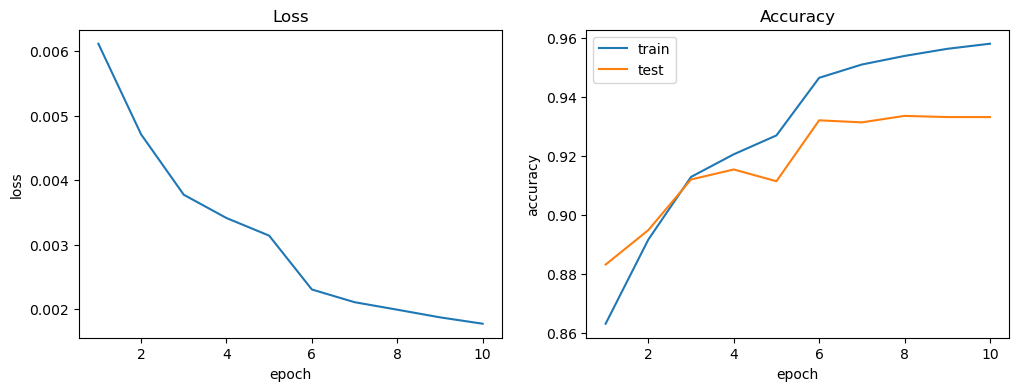

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(range(1, len(log_l) + 1), log_l)
axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(1, len(log_acc_tr) + 1), log_acc_tr, label='train')
axs[1].plot(range(1, len(log_acc_ts) + 1), log_acc_ts, label='test')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()

In [29]:
test_acc = evaluate_accuracy(fine_test_iter, fine_model, device)
print(f'accuracy: {test_acc*100:.1f}%')

accuracy: 93.4%


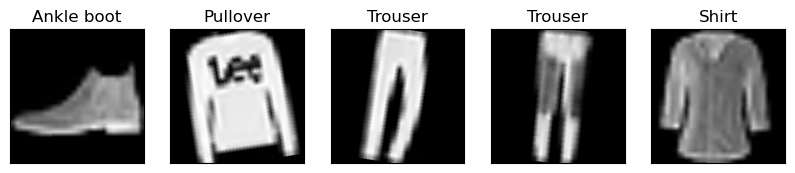

In [40]:
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])

def denormalize(img):
    # from normalized to 0...255
    img = img * std[:,None, None] + mean[:, None, None]
    return img.clamp(0,1) # pixel value between [0,1]
    
fig, axs = plt.subplots(1,5, figsize=(10,4))
for i in range(5):
  img = fine_test_dataset[i][0]
  axs[i].imshow(denormalize(img).permute(1,2,0).numpy(), cmap='gray');
  axs[i].set_xticks([]), axs[i].set_yticks([])
  pred_label = fine_model(img.unsqueeze(0).to(device)).argmax(axis=1).item()
  axs[i].set_title(class_names[pred_label])

In [31]:
torch.save(fine_model, 'fashion_model.pth')